In [1]:
import pandas as pd
import numpy as np
import csv
import math
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
from natsort import natsorted
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import itertools
import cv2 as cv
import h5py
from PIL import Image


Paths are for dataset tagged: all


In [2]:
# read through each metadata file and fix framestamp rollover
metadata_file = glob.glob(os.path.join(paths['raw_data'],'sessionproperties*.csv'))
print(metadata_file)

numRepeats = np.zeros(len(metadata_file))
time = []
framestamp = []
Frames = []
for i in range(len(metadata_file)):
    metadata = pd.read_csv(metadata_file[i])

width = metadata.Width[0]
print(width)
Xoffset = metadata.Left[0]
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.Top[0]
print(Yoffset)

['C:\\AIND\\output_data\\Tiffs_2024-08-13T12_16_47.8730496-07_00\\sessionproperties_2024-08-13T12_16_47.csv']
2012
20
228
548


In [28]:
# Load TTL file and timestamp csv

TTL_file = glob.glob(os.path.join(paths['raw_data'],'TTL*'))
print(TTL_file)

# Timestamp for TTL    
with open(TTL_file[1]) as f:
    reader = csv.reader(f)
    datatemp = np.array([row for row in reader])
    TTLts = datatemp[0:,:].astype(np.float32)

TTL_signal = np.fromfile(TTL_file[0])

# Split the TTL signal into its individual sources
TTL_signal1 = TTL_signal[0::2]
TTL_signal2 = TTL_signal[1::2]

['C:\\AIND\\output_data\\Tiffs_2024-08-13T12_16_47.8730496-07_00\\TTL_2024-08-13T12_16_47.8848640-07_00', 'C:\\AIND\\output_data\\Tiffs_2024-08-13T12_16_47.8730496-07_00\\TTL_TS2024-08-13T12_16_47.csv']


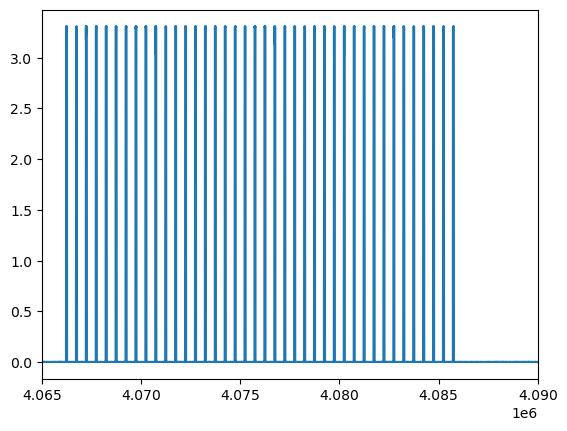

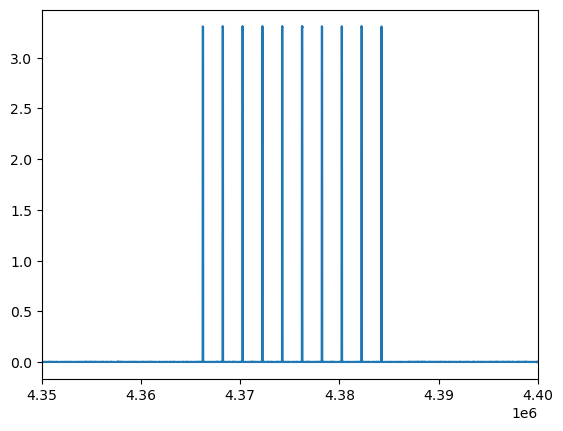

In [39]:
# Plot TTL signal 2

plt.plot(TTL_signal2)
plt.xlim(4065000, 4090000)
plt.show()

plt.plot(TTL_signal2)
plt.xlim(4350000, 4400000)
plt.show()


In [ ]:
# read through each metadata file and fix framestamp rollover
metadata_file = glob.glob(os.path.join(paths['raw_data'],'*.csv'))
print(metadata_file)

numFrames = np.zeros(len(metadata_file))
time = []
framestamp = []
Frames = []
for i in range(len(metadata_file)):
    metadata = pd.read_csv(metadata_file[i])
    numFrames[i] = len(metadata.Width)
    numFrames[i] = numFrames[i].astype(int)
    timestamp = metadata.CameraTimestamp #metadata.CameraTimestampSeconds + 10**-6*metadata.CameraTimestampMicroSeconds
    time.append(timestamp)

    framestamp = metadata.Framestamp
    framestamp = np.array(framestamp)
    bitmax = np.where(framestamp == 65535)
    if len(bitmax[0]) == 1:
        cut = framestamp[bitmax[0][0]+1:-1]
        newcut = cut + 65535
        Frames.append(np.concatenate((framestamp[0:bitmax[0][0]],newcut)))
    elif len(bitmax[0]) > 1:
        temp = []
        temp.append(np.array(framestamp[0:bitmax[0][0]]))
        for j in range(len(bitmax[0])-1):
            cut = temp[j][-1] + framestamp[bitmax[0][j]+1:bitmax[0][j+1]]
            temp.append(cut)
        temp.append(temp[j+1][-1] + framestamp[bitmax[0][-1]+1:-1])
        Frames.append(np.concatenate(temp))
    elif len(bitmax[0]) == 0:
        Frames.append(framestamp[0:-1])

width = metadata.Width[0]
print(width)
Xoffset = metadata.Left[0]
print(Xoffset)
height = metadata.Height[0]
print(height)
Yoffset = metadata.Top[0]
print(Yoffset)

In [3]:
# Unskew image, rotation followed by affine transformation

# Read from calibration.txt
with open(paths['raw_data'] / 'calibration.txt', 'r') as f:
    for line in f:
        name, value = line.strip().split(' = ')
        exec(f'{name} = {value}')

# Read from above txt file after running preprocess_01_unskewimage
theta_r = rot_tform_thetaR
pt1 = [aff_tform_pt1[0]-Xoffset, aff_tform_pt1[1]-Yoffset] 
pt2 = [aff_tform_pt2[0]-Xoffset, aff_tform_pt2[1]-Yoffset] 
pt3 = [aff_tform_pt3[0]-Xoffset, aff_tform_pt3[1]-Yoffset] 
pt4 = [aff_tform_pt4[0]-Xoffset, aff_tform_pt4[1]-Yoffset] 
pt5 = [aff_tform_pt5[0]-Xoffset, aff_tform_pt5[1]-Yoffset] 
pt6 = [aff_tform_pt6[0]-Xoffset, aff_tform_pt6[1]-Yoffset]
fiber1_location = [fiber1_pixels[1]-Yoffset,fiber1_pixels[0]-Yoffset]
fiber2_location = [fiber2_pixels[1]-Yoffset,fiber2_pixels[0]-Yoffset]

# Create rotation and affine transformation matrix
rows,cols = [height, width]
M1 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),theta_r,1)
pts1 = np.float32([pt1, pt2, pt3])
pts2 = np.float32([pt4, pt5, pt6])
M2 = cv.getAffineTransform(pts1,pts2)

In [4]:
# Get all Tiff directories
files = os.listdir(paths['raw_data'])
print(files)
folders = []
for entry in os.scandir(paths['raw_data']):
    if entry.is_dir():
        folders.append(entry.name)
folders = natsorted(folders)
print(folders)

# Read through each Tiff directory, exrtact tiff files, and unskew images
fiber1 = []
fiber2 = []
peaks = []

for i in range(len(folders)):
    print(folders[i])
    files = os.listdir(os.path.join(paths['raw_data'],folders[i]))
    files = natsorted(files)
    num = len(files) #int(''.join(filter(str.isdigit, files[-1])))
    print(num)
    tiffbatch = 1000
    sz_x = tiffbatch*num
    sz_y = width
    tempfiber1 = np.zeros([sz_x, sz_y])
    tempfiber2 = np.zeros([sz_x, sz_y])
    peak = np.zeros(sz_x)
    r = np.arange(2,num)
    image = []
    frame = 0

    for j in r:
        print(files[j])
        tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[j])

        # Open the TIFF file
        tiff_image = Image.open(tiff_file_path)
        # Initialize a list to store all the valid images
       
        while True:
            try:
                # Attempt to read the current frame and convert it to a NumPy array
                frame_array = np.array(tiff_image)

                temp_rotated = cv.warpAffine(frame_array,M1,(cols,rows))
                img = cv.warpAffine(temp_rotated,M2,(cols,rows))
                fiber1_m = np.mean(img[fiber1_location[1]:fiber1_location[0],:],axis=0)
                fiber2_m = np.mean(img[fiber2_location[1]:fiber2_location[0],:],axis=0)
                
                temp_peak, _ = find_peaks(fiber1_m,height=200,distance=200)
                if len(temp_peak) > 1:
                    max_peak = np.argmax(fiber1_m[temp_peak])
                    temp_peak = temp_peak[max_peak]

                fiber1_m = np.expand_dims(fiber1_m, axis=0)
                fiber2_m = np.expand_dims(fiber2_m, axis=0)

                tempfiber1[frame,:] = fiber1_m
                tempfiber2[frame,:] = fiber2_m
                peak[frame] = temp_peak


                # print(f"Successfully processed frame {frame}")
                # Move to the next frame
                tiff_image.seek(tiff_image.tell() + 1)
                frame += 1
            except EOFError:
                # End of the TIFF sequence, exit the loop
                # print("End of TIFF sequence reached.")
                break
            except Exception as e:
                # Catch any exception (like ValueError for corrupted frames)
                # print(f"Skipping corrupted frame {frame} due to error: {e}")
                # Move to the next frame even if this one is corrupted
                try:
                    tiff_image.seek(tiff_image.tell() + 1)
                    frame += 1
                except EOFError:
                    # If seeking to the next frame throws an EOFError, end the loop
                    # print("End of TIFF sequence reached after skipping a corrupted frame.")
                    break

    fiber1.append(tempfiber1)
    fiber2.append(tempfiber2)
    peaks.append(peak)

['calibration.txt', 'CalibrationImage.tiff', 'hsfp_rig.json', 'ophys_session.json', 'pixel_to_nm.hdf5', 'sessionproperties_2024-08-13T12_16_47.csv', 'Tiffs', 'TTL_2024-08-13T12_16_47.8848640-07_00', 'TTL_TS2024-08-13T12_16_47.csv']
['Tiffs']
Tiffs
187
Tiffs48.tif
Tiffs49.tif
Tiffs50.tif
Tiffs51.tif
Tiffs52.tif
Tiffs53.tif
Tiffs54.tif
Tiffs55.tif
Tiffs56.tif
Tiffs57.tif
Tiffs58.tif
Tiffs59.tif
Tiffs60.tif
Tiffs61.tif
Tiffs62.tif
Tiffs63.tif
Tiffs64.tif
Tiffs65.tif
Tiffs66.tif
Tiffs67.tif
Tiffs68.tif
Tiffs69.tif
Tiffs70.tif
Tiffs71.tif
Tiffs72.tif
Tiffs73.tif
Tiffs74.tif
Tiffs75.tif
Tiffs76.tif
Tiffs77.tif
Tiffs78.tif
Tiffs79.tif
Tiffs80.tif
Tiffs81.tif
Tiffs82.tif
Tiffs83.tif
Tiffs84.tif
Tiffs85.tif
Tiffs86.tif
Tiffs87.tif
Tiffs88.tif
Tiffs89.tif
Tiffs90.tif
Tiffs91.tif
Tiffs92.tif
Tiffs93.tif
Tiffs94.tif
Tiffs95.tif
Tiffs96.tif
Tiffs97.tif
Tiffs98.tif
Tiffs99.tif
Tiffs100.tif
Tiffs101.tif
Tiffs102.tif
Tiffs103.tif
Tiffs104.tif
Tiffs105.tif
Tiffs106.tif
Tiffs107.tif
Tiffs108.tif
Tiffs10

c:\Users\svc_aind_imaging\AppData\Local\miniconda3\envs\HSFPpreprocess\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 8 bytes but only got 0. 
  warnings.warn(str(msg))


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [5]:
fiber1.append(tempfiber1)
fiber2.append(tempfiber2)
peaks.append(peak)

fiber1 = fiber1[0][0:frame,:]
fiber2 = fiber2[0][0:frame,:]
peaks = peaks[0][0:frame]

In [6]:
# Set order of lasers and interleave into individual laser channels

c = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Camera_pixel', more='r')
w = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Wavelength_nm', more='r')
wavelength = w.to_numpy()
camera_px = c.to_numpy()
lasers = [405,445,473,514,560]

laser_order = []
l_order = np.zeros(len(peaks))
for j in range(len(peaks)):
    laser_pix = min(camera_px, key=lambda x:abs(x-peaks[j]-Xoffset))
    camera_pix = np.where(camera_px>laser_pix)
    p = camera_pix[-1]
    p = p[-1]
    temp_laser = min(lasers, key=lambda x:abs(x-wavelength[p]))
    l_order[j] = temp_laser
laser_order.append(l_order)
print(laser_order)

[array([405., 445., 473., ..., 405., 445., 473.])]


In [ ]:
L405_idx = np.where(laser_order[0]==405)
L405_idx = np.array(L405_idx[0])

print(L405_idx)

In [7]:
# Interleave signals from each fiber into the five laser channels

laser_order = laser_order[0]
L405_idx = np.where(laser_order==405)
L405_idx = np.array(L405_idx[0])
F1_405 = fiber1[L405_idx,:]
F2_405 = fiber2[L405_idx,:]
L445_idx = np.where(laser_order==445)
L445_idx = np.array(L445_idx[0])
F1_445 = fiber1[L445_idx,:]
F2_445 = fiber2[L445_idx,:]
L473_idx = np.where(laser_order==473)
L473_idx = np.array(L473_idx[0])
F1_473 = fiber1[L473_idx,:]
F2_473 = fiber2[L473_idx,:]
L514_idx = np.where(laser_order==514)
L514_idx = np.array(L514_idx[0])
F1_514 = fiber1[L514_idx,:]
F2_514 = fiber2[L514_idx,:]
L560_idx = np.where(laser_order==560)
L560_idx = np.array(L560_idx[0])
F1_560 = fiber1[L560_idx,:]
F2_560 = fiber2[L560_idx,:]


In [8]:
LCh405_F1 = F1_405
LCh405_F2 = F2_405
LCh445_F1 = F1_445
LCh445_F2 = F2_445
LCh473_F1 = F1_473
LCh473_F2 = F2_473
LCh514_F1 = F1_514
LCh514_F2 = F2_514
LCh560_F1 = F1_560
LCh560_F2 = F2_560


In [9]:
# Convert pixel data into wavelength data

LCh_405_F1 = np.zeros([LCh405_F1.shape[0], wavelength.shape[0]])
LCh_405_F2 = np.zeros([LCh405_F2.shape[0], wavelength.shape[0]])
LCh_445_F1 = np.zeros([LCh445_F1.shape[0], wavelength.shape[0]])
LCh_445_F2 = np.zeros([LCh445_F2.shape[0], wavelength.shape[0]])
LCh_473_F1 = np.zeros([LCh473_F1.shape[0], wavelength.shape[0]])
LCh_473_F2 = np.zeros([LCh473_F2.shape[0], wavelength.shape[0]])
LCh_514_F1 = np.zeros([LCh514_F1.shape[0], wavelength.shape[0]])
LCh_514_F2 = np.zeros([LCh514_F2.shape[0], wavelength.shape[0]])
LCh_560_F1 = np.zeros([LCh560_F1.shape[0], wavelength.shape[0]])
LCh_560_F2 = np.zeros([LCh560_F2.shape[0], wavelength.shape[0]])

for px in range(0,wavelength.shape[0]):
    LCh_405_F1[:,px] = LCh405_F1[:,camera_px[px]-Xoffset]
    LCh_405_F2[:,px] = LCh405_F2[:,camera_px[px]-Xoffset]
    LCh_445_F1[:,px] = LCh445_F1[:,camera_px[px]-Xoffset]
    LCh_445_F2[:,px] = LCh445_F2[:,camera_px[px]-Xoffset]
    LCh_473_F1[:,px] = LCh473_F1[:,camera_px[px]-Xoffset]
    LCh_473_F2[:,px] = LCh473_F2[:,camera_px[px]-Xoffset]
    LCh_514_F1[:,px] = LCh514_F1[:,camera_px[px]-Xoffset]
    LCh_514_F2[:,px] = LCh514_F2[:,camera_px[px]-Xoffset]
    LCh_560_F1[:,px] = LCh560_F1[:,camera_px[px]-Xoffset]
    LCh_560_F2[:,px] = LCh560_F2[:,camera_px[px]-Xoffset]

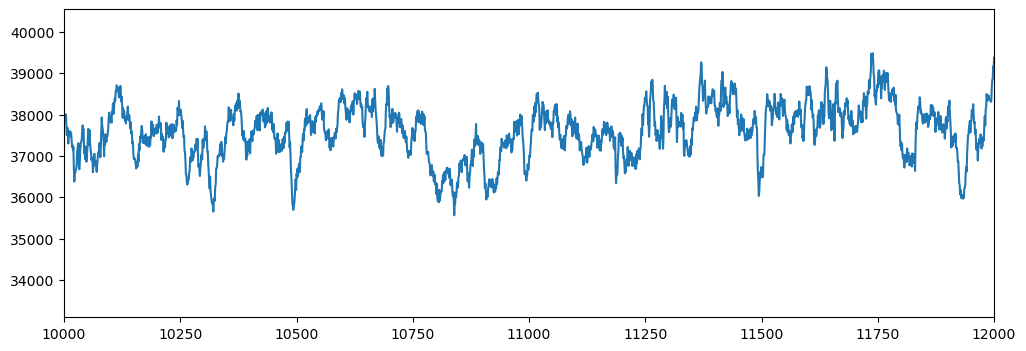

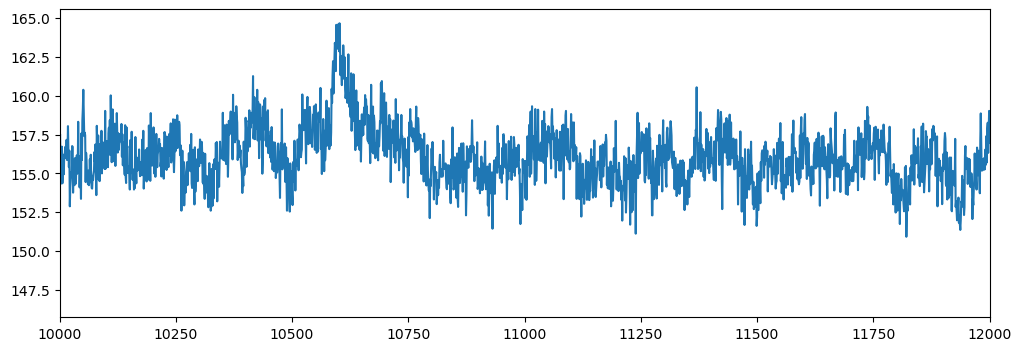

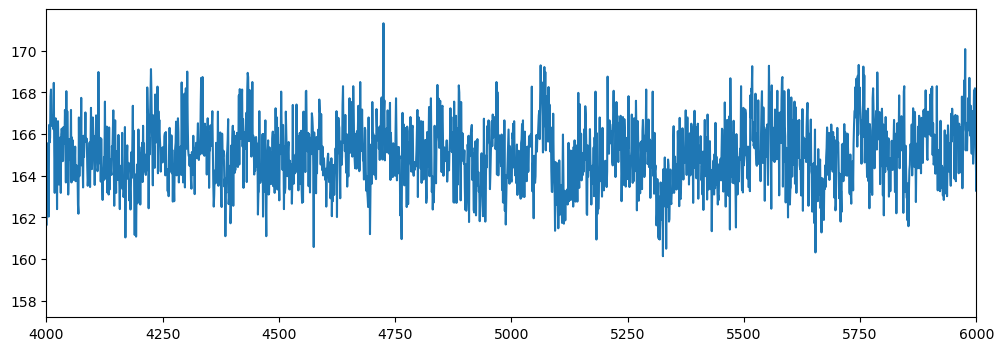

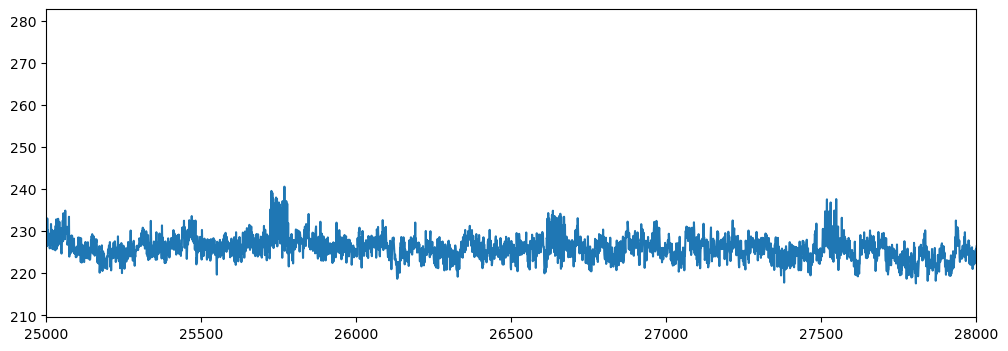

In [56]:
# plot the data
plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_473_F2[:,473-400])
plt.xlim([10000, 12000])
plt.show()

plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_473_F2[:,500-400])
plt.xlim([10000, 12000])
plt.show()

plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_514_F2[:,540-400])
plt.xlim([4000, 6000])
plt.show()


plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_560_F2[:,600-400])
plt.xlim([25000, 28000])
plt.show()

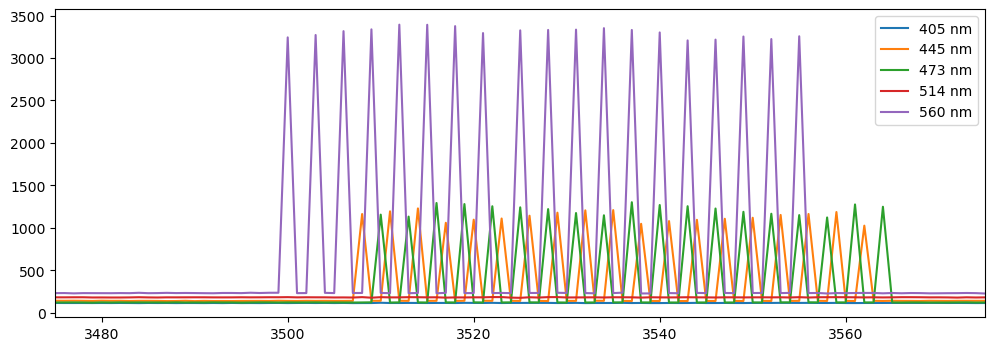

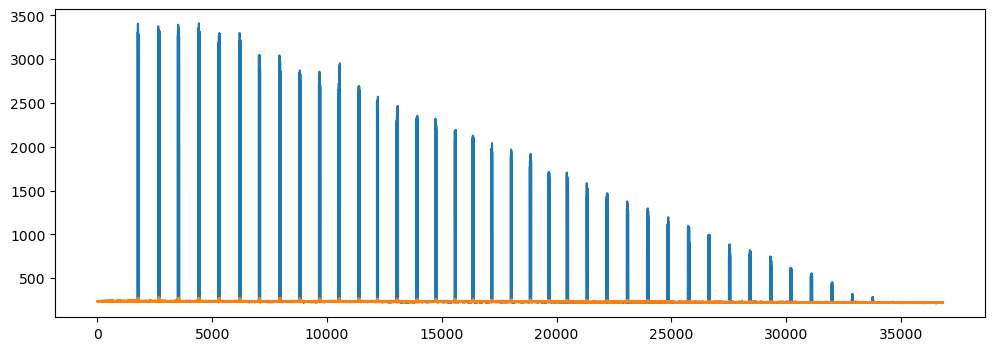

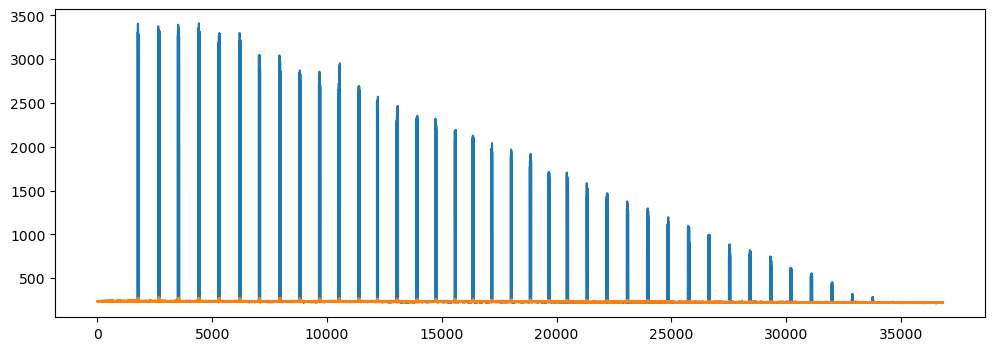

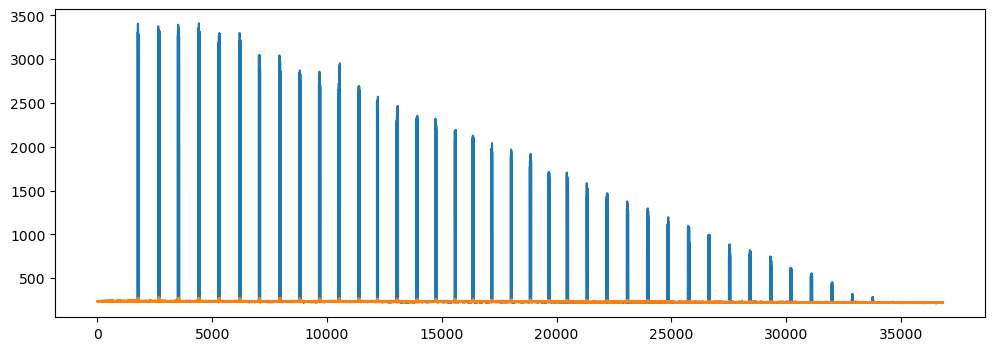

In [27]:
# Plot the data

plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_405_F2[:,630-400])
plt.plot(LCh_445_F2[:,630-400])
plt.plot(LCh_473_F2[:,630-400])
plt.plot(LCh_514_F2[:,630-400])
plt.plot(LCh_560_F2[:,630-400])
plt.xlim([2600,2800])
plt.xlim([3475,3575])
plt.legend(['405 nm', '445 nm', '473 nm', '514 nm', '560 nm'])
plt.show()


def plot_data(data,xlim):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.plot(data[:,630-400])
    plt.plot(data[:,600-400])
    #plt.xlim(xlim)
    plt.show()
plot_data(LCh_560_F2, [1600, 1800])
plot_data(LCh_560_F2, [2500, 2700])
plot_data(LCh_560_F2, [3400, 3600])



In [ ]:
# Get all Tiff directories
files = os.listdir(paths['raw_data'])
print(files)
folders = []
for entry in os.scandir(paths['raw_data']):
    if entry.is_dir():
        folders.append(entry.name)
folders = natsorted(folders)
print(folders)

# Read through each Tiff directory, exrtact tiff files, and unskew images
fiber1 = []
fiber2 = []
peaks = []
tiffbatch = 8000
for i in range(len(folders)):
    print(folders[i])
    files = os.listdir(os.path.join(paths['raw_data'],folders[i]))
    files = natsorted(files)
    num_files = np.size(files,0)
    tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[0])
    temp = io.imread(tiff_file_path).astype(float)
    num = len(files) #int(''.join(filter(str.isdigit, files[-1])))
    lenToUse = min(num,math.floor(len(time[i])/1000)) #Changed for ocamp testing 2024_08_05
    sz_x = tiffbatch*lenToUse
    sz_y = width
    tempfiber1 = np.zeros([sz_x, sz_y])
    tempfiber2 = np.zeros([sz_x, sz_y])
    peak = np.zeros(sz_x)
    for j in range(lenToUse):
    # for j in range(num_files-1):
        print(files[j])
        # Extract the number in the filename and convert to integer
        num = int(''.join(filter(str.isdigit, files[j])))
        tiff_file_path = os.path.join(paths['raw_data'],folders[i],files[j])
        temp = io.imread(tiff_file_path).astype(float)
        background = np.mean(temp[:,0:20,0:200]) # Top corner left pixels are used for background subtraction
        for frame in range(temp.shape[0]):
            temp_rotated = cv.warpAffine(temp[frame,:,:],M1,(cols,rows))
            img = cv.warpAffine(temp_rotated,M2,(cols,rows))
            img = img - background
            fiber1_m = np.mean(img[fiber1_location[1]:fiber1_location[0],:],axis=0)
            fiber2_m = np.mean(img[fiber2_location[1]:fiber2_location[0],:],axis=0)
            
            temp_peak, _ = find_peaks(fiber1_m,height=200-background,distance=200)
            if len(temp_peak) > 1:
                max_peak = np.argmax(fiber1_m[temp_peak])
                temp_peak = temp_peak[max_peak]

            fiber1_m = np.expand_dims(fiber1_m, axis=0)
            fiber2_m = np.expand_dims(fiber2_m, axis=0)
            if j == 0:
                tempfiber1[frame,:] = fiber1_m
                tempfiber2[frame,:] = fiber2_m
                peak[frame] = temp_peak
            else:
                tempfiber1[num*tiffbatch + frame,:] = fiber1_m
                tempfiber2[num*tiffbatch + frame,:] = fiber2_m
                peak[num*tiffbatch + frame] = temp_peak

    fiber1.append(tempfiber1)
    fiber2.append(tempfiber2)
    peaks.append(peak)

# Truncate time vectors to match the length of tiff files
for i in range(len(time)):
    if time[i].shape > fiber1[i].shape:
        time[i] = time[i][0:fiber1[i].shape[0]]

In [ ]:
# Set order of lasers and interleave into individual laser channels

c = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Camera_pixel', more='r')
w = pd.read_hdf(paths['raw_data']/'pixel_to_nm.hdf5', key='Wavelength_nm', more='r')
wavelength = w.to_numpy()
camera_px = c.to_numpy()
lasers = [405,445,473,514,560]

laser_order = []
for i in range(len(peaks)):
    l_order = np.zeros(len(peaks[i]))
    for j in range(len(peaks[i])):
        laser_pix = min(camera_px, key=lambda x:abs(x-peaks[i][j]-Xoffset))
        camera_pix = np.where(camera_px>laser_pix)
        p = camera_pix[-1]
        p = p[-1]
        temp_laser = min(lasers, key=lambda x:abs(x-wavelength[p]))
        l_order[j] = temp_laser
    laser_order.append(l_order)
print(laser_order)

In [ ]:
# Interleave signals from each fiber into the five laser channels
L405_F1 = []
L445_F1 = []
L473_F1 = []
L514_F1 = []
L560_F1 = []
L405_F2 = []
L445_F2 = []
L473_F2 = []
L514_F2 = []
L560_F2 = []
time_405 = []
time_445 = []
time_473 = []
time_514 = []
time_560 = []

for i in range(len(folders)):
    L405_idx = np.where(laser_order[i]==405)
    L405_idx = np.array(L405_idx[0])
    F1_405 = fiber1[i][L405_idx,:]
    F2_405 = fiber2[i][L405_idx,:]
    temptime_405 = np.array(time[i][L405_idx])
    L445_idx = np.where(laser_order[i]==445)
    L445_idx = np.array(L445_idx[0])
    F1_445 = fiber1[i][L445_idx,:]
    F2_445 = fiber2[i][L445_idx,:]
    temptime_445 = np.array(time[i][L445_idx])
    L473_idx = np.where(laser_order[i]==473)
    L473_idx = np.array(L473_idx[0])
    F1_473 = fiber1[i][L473_idx,:]
    F2_473 = fiber2[i][L473_idx,:]
    temptime_473 = np.array(time[i][L473_idx])
    L514_idx = np.where(laser_order[i]==514)
    L514_idx = np.array(L514_idx[0])
    F1_514 = fiber1[i][L514_idx,:]
    F2_514 = fiber2[i][L514_idx,:]
    temptime_514 = np.array(time[i][L514_idx])
    L560_idx = np.where(laser_order[i]==560)
    L560_idx = np.array(L560_idx[0])
    F1_560 = fiber1[i][L560_idx,:]
    F2_560 = fiber2[i][L560_idx,:]
    temptime_560 = np.array(time[i][L560_idx])
    
    L405_F1.append(F1_405)
    L445_F1.append(F1_445)
    L473_F1.append(F1_473)
    L514_F1.append(F1_514)
    L560_F1.append(F1_560)
    L405_F2.append(F2_405)
    L445_F2.append(F2_445)
    L473_F2.append(F2_473)
    L514_F2.append(F2_514)
    L560_F2.append(F2_560)
    time_405.append(temptime_405)
    time_445.append(temptime_445)
    time_473.append(temptime_473)
    time_514.append(temptime_514)
    time_560.append(temptime_560)

In [ ]:
# Concatenate signals from all frame folders into a single sequence
LCh405_F1 = np.concatenate(L405_F1)
LCh445_F1 = np.concatenate(L445_F1)
LCh473_F1 = np.concatenate(L473_F1)
LCh514_F1 = np.concatenate(L514_F1)
LCh560_F1 = np.concatenate(L560_F1)
LCh405_F2 = np.concatenate(L405_F2)
LCh445_F2 = np.concatenate(L445_F2)
LCh473_F2 = np.concatenate(L473_F2)
LCh514_F2 = np.concatenate(L514_F2)
LCh560_F2 = np.concatenate(L560_F2)
lasers = np.concatenate(laser_order)
timeseries_405 = np.concatenate(time_405)
timeseries_445 = np.concatenate(time_445)
timeseries_473 = np.concatenate(time_473)
timeseries_514 = np.concatenate(time_514)
timeseries_560 = np.concatenate(time_560)
full_time = np.concatenate(time)

In [ ]:
# Convert pixel data into wavelength data

LCh_405_F1 = np.zeros([LCh405_F1.shape[0], wavelength.shape[0]])
LCh_405_F2 = np.zeros([LCh405_F2.shape[0], wavelength.shape[0]])
LCh_445_F1 = np.zeros([LCh445_F1.shape[0], wavelength.shape[0]])
LCh_445_F2 = np.zeros([LCh445_F2.shape[0], wavelength.shape[0]])
LCh_473_F1 = np.zeros([LCh473_F1.shape[0], wavelength.shape[0]])
LCh_473_F2 = np.zeros([LCh473_F2.shape[0], wavelength.shape[0]])
LCh_514_F1 = np.zeros([LCh514_F1.shape[0], wavelength.shape[0]])
LCh_514_F2 = np.zeros([LCh514_F2.shape[0], wavelength.shape[0]])
LCh_560_F1 = np.zeros([LCh560_F1.shape[0], wavelength.shape[0]])
LCh_560_F2 = np.zeros([LCh560_F2.shape[0], wavelength.shape[0]])

for px in range(0,wavelength.shape[0]):
    LCh_405_F1[:,px] = LCh405_F1[:,camera_px[px]-Xoffset]
    LCh_405_F2[:,px] = LCh405_F2[:,camera_px[px]-Xoffset]
    LCh_445_F1[:,px] = LCh445_F1[:,camera_px[px]-Xoffset]
    LCh_445_F2[:,px] = LCh445_F2[:,camera_px[px]-Xoffset]
    LCh_473_F1[:,px] = LCh473_F1[:,camera_px[px]-Xoffset]
    LCh_473_F2[:,px] = LCh473_F2[:,camera_px[px]-Xoffset]
    LCh_514_F1[:,px] = LCh514_F1[:,camera_px[px]-Xoffset]
    LCh_514_F2[:,px] = LCh514_F2[:,camera_px[px]-Xoffset]
    LCh_560_F1[:,px] = LCh560_F1[:,camera_px[px]-Xoffset]
    LCh_560_F2[:,px] = LCh560_F2[:,camera_px[px]-Xoffset]
    

In [ ]:
# Regress laser noise from 445 and 473 channels (just testing)

# High pass filter the signal
# Scale noise linearly to signal 
# Subtract scaled noise from signal
# Add signal back to low frequency component of original signal

from scipy import signal

def butter_highpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

fps = 24
sig_px = 500
noise_px = 473
# Low pass filter the signal
pass_freq = 5
lowfilt_sig = butter_lowpass_filter(LCh_473_F2[:,sig_px-400],pass_freq,fps)
# lowfilt_noise = butter_lowpass_filter(LCh_445_F2[:,noise_px-400],pass_freq,fps)
noise = LCh_473_F2[:,noise_px-400]
A = np.vstack([noise, np.ones(len(noise))]).T
[x,y] = np.linalg.lstsq(A, lowfilt_sig, rcond=None)[0]
scl_noise = x*noise + y
final_sig = lowfilt_sig - scl_noise + np.mean(lowfilt_sig)

# Plot the denoised signal
def plot_signal(signal, title):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.plot(signal)
    plt.title(title)
    plt.xlim([0, 2000])
    plt.show()

plot_signal(LCh_473_F2[:,sig_px-400], 'Original Signal')
plot_signal(lowfilt_sig, 'Low Pass Filtered Signal')
plot_signal(scl_noise, 'Scaled Noise')
plot_signal(final_sig, 'Final Signal')
plot_signal(lowfilt_sig, 'Low Pass Filtered Signal')

In [ ]:

# Regress laser noise from 445 and 473 channels

# High pass filter the signal
# Scale noise linearly to signal 
# Subtract scaled noise from signal
# Add signal back to low frequency component of original signal

from scipy import signal

def butter_highpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=1):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Low pass filter the signal
fps = 24
noise_px = 473
pass_freq = 5

def denoise_signal(sig, noise_px, pass_freq, fps):
    new_sig = np.zeros(sig.shape)
    for i in range(0,len(sig[0,:])):
        lowfilt_sig = butter_lowpass_filter(sig[:,i],pass_freq,fps)
        noise = sig[:,noise_px-400]
        A = np.vstack([noise, np.ones(len(noise))]).T
        [x,y] = np.linalg.lstsq(A, lowfilt_sig, rcond=None)[0]
        scl_noise = x*noise + y
        final_sig = lowfilt_sig - scl_noise + np.mean(lowfilt_sig)
        new_sig[:,i] = final_sig
    return new_sig

noise_px = 445
denoised_signal_445_F1 = denoise_signal(LCh_445_F1, noise_px, pass_freq, fps)
denoised_signal_445_F2 = denoise_signal(LCh_445_F2, noise_px, pass_freq, fps)
noise_px = 473
denoised_signal_473_F1 = denoise_signal(LCh_473_F1, noise_px, pass_freq, fps)
denoised_signal_473_F2 = denoise_signal(LCh_473_F2, noise_px, pass_freq, fps)

# Low pass filter the other signals
pass_freq = 5
filtered_405_F1 = butter_lowpass_filter(LCh_405_F1,pass_freq,fps)
filtered_405_F2 = butter_lowpass_filter(LCh_405_F2,pass_freq,fps)
filtered_514_F1 = butter_lowpass_filter(LCh_514_F1,pass_freq,fps)
filtered_514_F2 = butter_lowpass_filter(LCh_514_F2,pass_freq,fps)
filtered_560_F1 = butter_lowpass_filter(LCh_560_F1,pass_freq,fps)
filtered_560_F2 = butter_lowpass_filter(LCh_560_F2,pass_freq,fps)

LCh_405_F1 = filtered_405_F1
LCh_405_F2 = filtered_405_F2
LCh_445_F1 = denoised_signal_445_F1
LCh_445_F2 = denoised_signal_445_F2
LCh_473_F1 = denoised_signal_473_F1
LCh_473_F2 = denoised_signal_473_F2
LCh_514_F1 = filtered_514_F1
LCh_514_F2 = filtered_514_F2
LCh_560_F1 = filtered_560_F1
LCh_560_F2 = filtered_560_F2


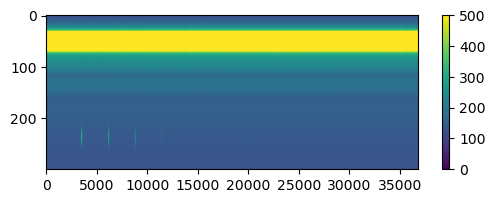

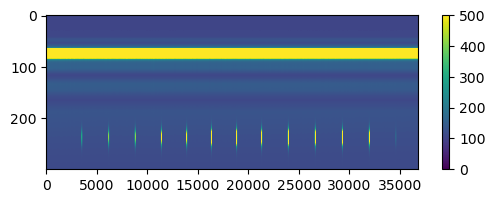

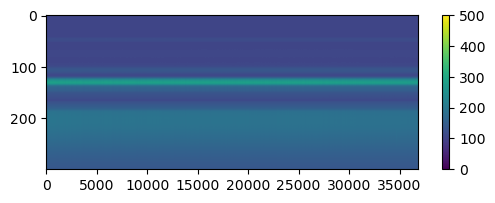

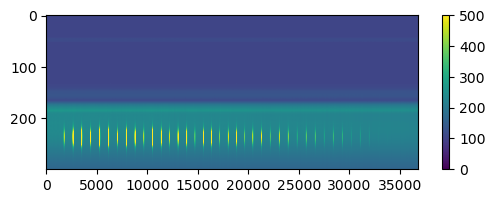

NameError: name 'timeseries_473' is not defined

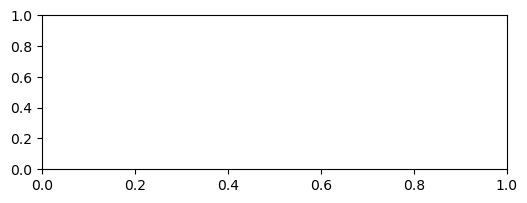

In [42]:

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(LCh_445_F2), aspect='auto', vmin=0, vmax=500)
#ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='473 nm', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(LCh_473_F2), aspect='auto', vmin=0, vmax=500)
#ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='473 nm', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(LCh_514_F2), aspect='auto', vmin=0, vmax=500)
#ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='473 nm', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
i = ax.imshow(np.transpose(LCh_560_F2), aspect='auto', vmin=0, vmax=500)
#ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='473 nm', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
norm_time = timeseries_473 - timeseries_473[0]
i = ax.imshow(np.transpose(denoised_signal_473), aspect='auto', vmin=0, vmax=500, 
              extent=[np.min(norm_time), np.max(norm_time), 699, 400])
ax.set(xlabel='Time (sec)', ylabel='Wavelength', title='473 nm', ylim=[400,699])
ax.grid(False)
f.colorbar(i,ax=ax)
plt.show()

plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(LCh_445_F2[:,500-400])
plt.xlim([50000, 51000])
plt.show()

plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.plot(denoised_signal_445[:,500-400])
plt.xlim([50000, 51000])
plt.show()

In [ ]:
# Save preprocessed data in hdf5 file

data_preprocessed = {'Time_405':timeseries_405, 'Time_445':timeseries_445, 'Time_473':timeseries_473, 'Time_514':timeseries_514, 
                        'Time_560':timeseries_560, 'Full_TimeStamps':full_time,'Lasers':lasers, 'Wavelength':wavelength, 
                        'Channel_405_F1':LCh_405_F1, 'Channel_445_F1':LCh_445_F1, 'Channel_473_F1':LCh_473_F1,
                        'Channel_514_F1':LCh_514_F1, 'Channel_560_F1':LCh_560_F1, 'Channel_405_F2':LCh_405_F2,
                        'Channel_445_F2':LCh_445_F2, 'Channel_473_F2':LCh_473_F2, 'Channel_514_F2':LCh_514_F2,
                        'Channel_560_F2':LCh_560_F2}
for key in data_preprocessed.keys():
    print(f'\n{key}')
    print(data_preprocessed[key])

# Write a new hdf5 file with all keys in data_preprocessed
hf = h5py.File(paths['raw_data'] / 'hsfp_data_preprocessed_noisereg.hdf5','w')
for key in data_preprocessed.keys():
    hf.create_dataset(key, data = data_preprocessed[key])
hf.close()

In [ ]:
# Plot a spectrogram image of LCh473_F1 as a check

plt.figure()
plt.imshow(LCh_405_F2.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_473_F2.T, aspect='auto', cmap='gray')
plt.show()

plt.figure()
plt.imshow(LCh_560_F2.T, aspect='auto', cmap='gray')
plt.show()